# Followers: What do they tweet about?

In [92]:
import pandas as pd
import numpy as np
import config
import sys
import re
from ast import literal_eval
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import wordcloud
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

pd.set_option('display.max_colwidth', 100)

In [93]:
target = config.target_user
target_month = config.target_month

In [94]:
source_dir = "{}/data/twitter/tweets/{}".format(config.dir_prefix, target)

tokenized_and_preprocessed_file = '/'.join([source_dir, target_month  + '_tokenized_and_preprocessed.csv'])
english_file = '/'.join([source_dir, target_month  + '_english.csv'])
french_file = '/'.join([source_dir, target_month  + '_french.csv'])
german_file = '/'.join([source_dir, target_month  + '_german.csv'])

## Tweets in English

In [95]:
tweets_english = pd.read_csv(english_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})

def remove_hash(wordlist):
    return(list(map(lambda x: re.sub(r'^#','',x), wordlist)))

def remove_at(wordlist):
    return(list(map(lambda x: re.sub(r'^@','',x), wordlist)))
    
tweets_english['text_wo_#'] = tweets_english['text_processed'].apply(lambda x: remove_hash(x))
tweets_english['text_wo_#@'] = tweets_english['text_wo_#'].apply(lambda x: remove_at(x))

X_train_en = tweets_english['text_wo_#@'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("english"))
#relevant_words = set(['not', 'nor', 'no', 'wasn', 'ain', 'aren', 'very', 'only', 'but', 'don', 'isn', 'weren'])
relevant_words = set()
additional_stopwords = set(['us'])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [96]:
X_train_en[-10:-1]

3682    albertocairo How do you pronounce data From jshkatz s Speaking American dataviz infographics dat...
3683                                                                                 lukaseder SQL IS A LIE
3684                        stevesi 1/2 Programmers really hate open floor plans https://t.co/uAwra5VnN6 qz
3685    oraclepartners The cloud is coming the cloud is coming 3 questions ISVs should be asking about t...
3686                         ChristianNagel codepo8 YouTube at least removing the old one seems to work ;-)
3687                                                 lukaseder yuck could this be some kind of optimization
3688    ArsTechnicaUK Spreadsheets have ruled Earth for too long Time for businesses to embrace the clou...
3689    An easy recipe for keeping oraclebase happy Make sure he can get to do laundry :-D Add an iron i...
3690                                     Out of food but good mood at SparkSummit 😉 https://t.co/eOJyV9Bzij
Name: text_wo_#@, dtype: obj

In [97]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_en)
feature_names = vectorizer.get_feature_names()

In [98]:
lda_models = []
for n_topics in range(1,5):    
    lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
    lda.fit(words_matrix)
    lda_models.append(lda)

In [99]:
def generate_word_cloud(model, topic_number, max_words, width, height):
    topic = model.components_[topic_number]
    frequencies = [(feature_names[i], topic[i]) for i in topic.argsort()]
    top_n = ['{}: {}'.format(round(topic[i],1), feature_names[i]) for i in topic.argsort()[:-n_top_words-1:-1]]
    cloud = wordcloud.WordCloud(width=width, height=height, max_words=max_words, random_state=0).generate_from_frequencies(frequencies)
    return cloud
  
def show_word_clouds(model, subplots, num_words):    
    for i in range(model.n_topics):
        wordcloud = generate_word_cloud(model = model, topic_number = i, max_words = num_words,width = 800, height = 600)
        subplots[i].imshow(wordcloud)
        subplots[i].axis('off')

def print_top_words(model, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        top_n = ['{}: {}'.format(round(topic[i],1), feature_names[i]) for i in topic.argsort()[:-n_top_words-1:-1]]
        print('\n'.join(top_n))
        print()
    


## Most dominating topics - overall

Topic #0:
479.2: oracle
250.1: data
248.0: new
223.5: cloud
213.3: lukaseder
163.7: sql
156.6: iamcp
150.7: talend
144.6: 2016
142.6: sfonplsql



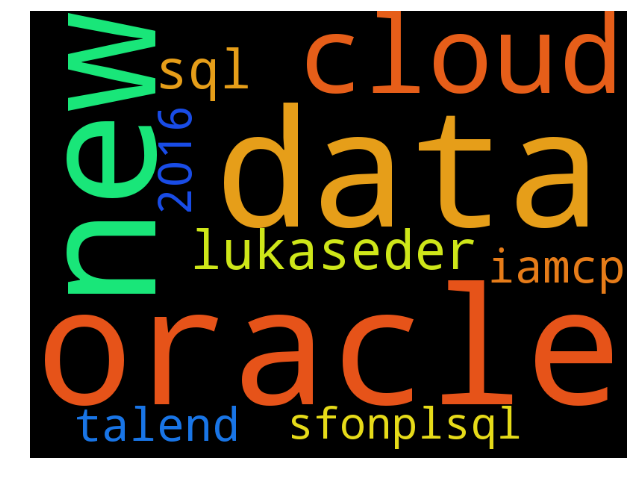

In [100]:
model = lda_models[0]
n_top_words = 10
print_top_words(model, n_top_words)

fig, ax1 = plt.subplots(figsize = (12, 8))
axes = [ax1]
show_word_clouds(model, axes, n_top_words)


## Most dominating topics - 2 clusters

Topic #0:
478.5: oracle
222.6: cloud
179.6: data
172.2: new
128.2: 2016
105.5: sql
101.5: database
77.6: 2
76.5: microsoft
75.3: october
69.6: iamcp
67.9: sfonplsql
66.9: 10
65.8: available
64.2: day
61.5: big
57.1: service
55.8: things
54.8: talend
53.6: business

Topic #1:
187.4: lukaseder
120.1: bigdata
118.4: thanks
98.4: one
97.8: great
95.9: talend
90.3: like
86.9: iamcp
81.3: don't
78.9: week
76.6: it's
75.8: new
74.7: sfonplsql
72.2: really
71.2: :)
71.1: ukoug
70.5: data
68.4: use
66.6: help
64.4: get



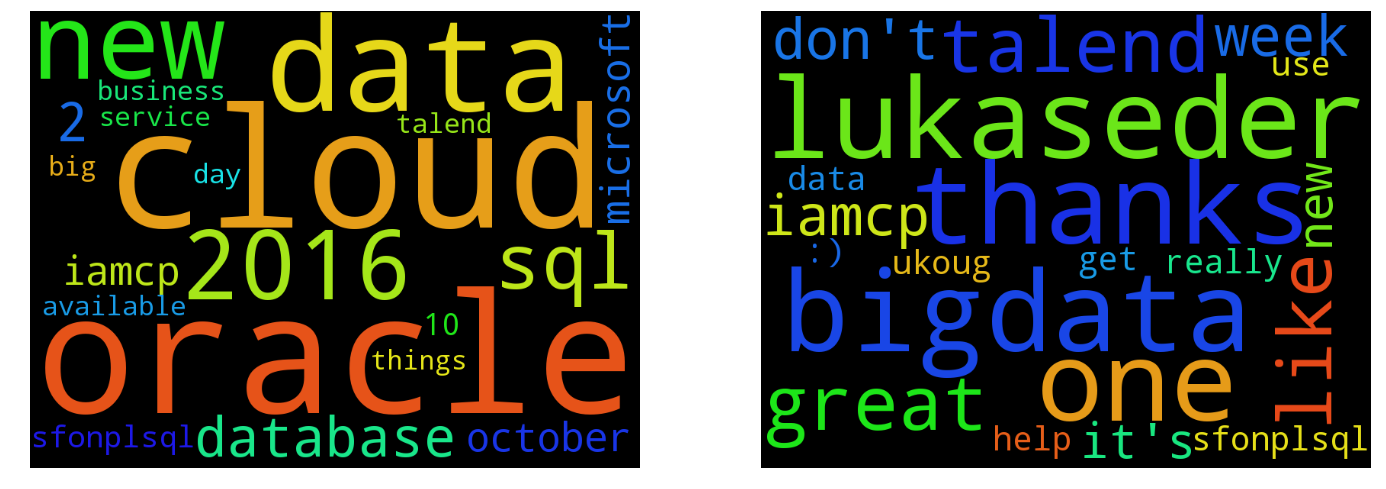

In [101]:
model = lda_models[1]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
axes = [ax1, ax2]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters

Topic #0:
474.5: oracle
186.2: cloud
178.4: new
143.8: 2016
101.3: database
98.7: sql
98.0: check
84.0: iamcp
81.2: get
75.1: october
74.4: sfonplsql
73.4: day
62.7: data
59.6: week
58.7: available
54.8: today
53.2: don't
50.9: service
49.7: 12.2
46.4: business

Topic #1:
127.8: thanks
104.1: great
93.3: talend
71.5: see
71.0: :)
70.1: iamcp
69.1: new
57.4: like
56.8: it's
55.6: best
53.0: time
51.9: need
48.5: post
47.1: work
45.4: way
45.3: microsoft
44.8: iot
44.5: 10
43.4: think
43.0: thank

Topic #2:
187.0: data
151.5: lukaseder
99.8: one
91.7: bigdata
71.0: ukoug
64.5: sql
61.9: hadoop
61.8: big
57.0: talend
51.9: sfonplsql
51.0: really
50.0: still
49.3: https
49.2: 1
45.0: analytics
43.8: keys
42.3: azure
39.6: make
39.5: zurich
38.9: vcfe_ch



(0.0, 1.0, 0.0, 1.0)

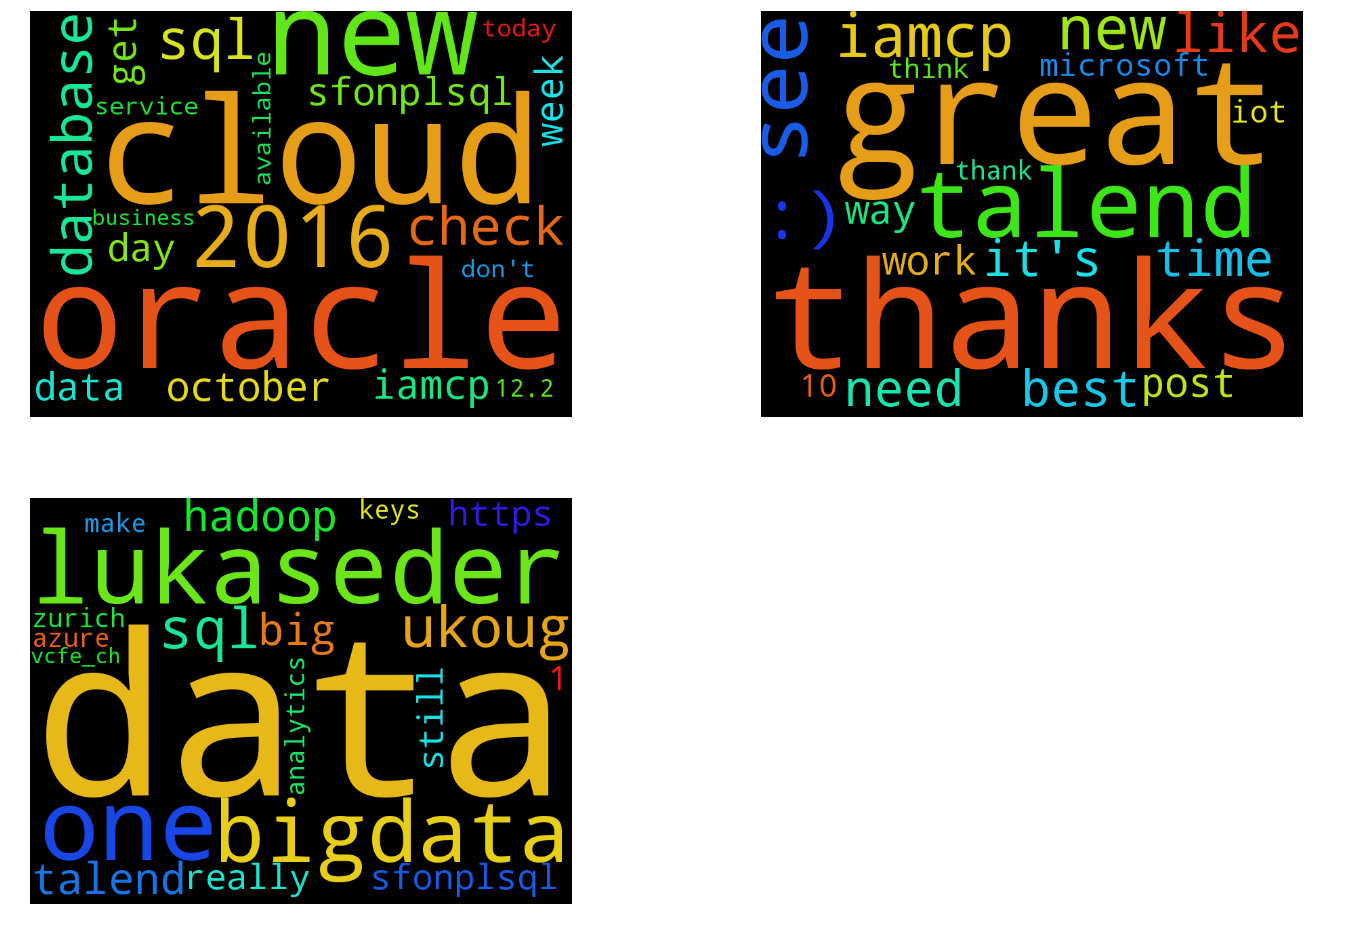

In [102]:
model = lda_models[2]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3]
show_word_clouds(model, axes, n_top_words)
ax4.axis('off')

## Most dominating topics - 4 clusters

Topic #0:
264.0: oracle
143.8: 2016
94.7: cloud
94.2: database
93.4: sql
86.4: get
75.1: october
50.0: check
47.4: sfonplsql
46.4: latest
45.4: soacommunity
44.2: day
41.2: available
40.9: java
38.2: digital
37.2: https://…
37.0: great
34.9: plsql
34.7: franckpachot
33.7: inside

Topic #1:
127.8: thanks
89.6: great
87.8: lukaseder
71.0: :)
67.6: like
62.8: it's
62.3: see
56.3: use
55.6: help
48.4: want
46.7: people
43.2: think
42.9: time
42.9: looking
41.4: one
39.5: need
38.5: zurich
38.1: don't
37.2: yes
35.9: vcfe_ch

Topic #2:
167.1: data
128.7: talend
120.2: bigdata
96.5: oracle
77.7: 2
77.6: new
71.2: ukoug
64.0: lukaseder
64.0: iot
61.9: hadoop
61.8: big
59.4: one
56.1: blog
51.5: post
49.2: 1
43.7: still
42.6: analytics
42.3: 10
39.6: back
39.2: performance

Topic #3:
167.9: new
118.2: oracle
100.3: week
94.7: sfonplsql
91.1: iamcp
82.5: data
80.9: cloud
60.3: sql
57.2: last
56.8: service
52.1: lukaseder
49.5: business
49.4: join
47.4: work
46.1: good
45.8: way
45.6: day
45.1: 

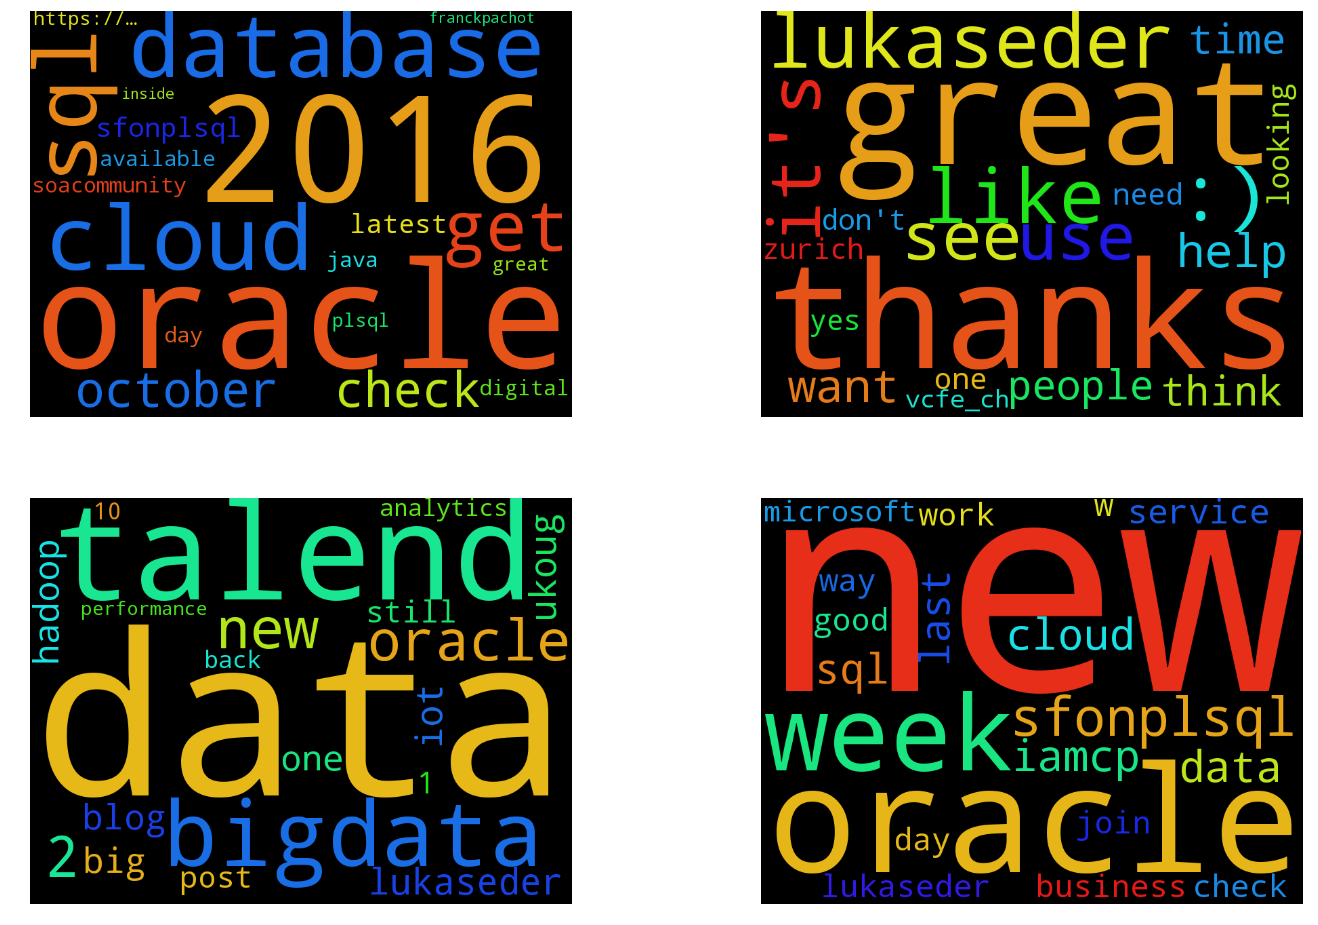

In [103]:
model = lda_models[3]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3, ax4]
show_word_clouds(model, axes, n_top_words)

In [104]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_en)

co_occurrence_matrix = words_matrix.T * words_matrix
co_occurrence_matrix.setdiag(0) 
array = co_occurrence_matrix.toarray()
co_occurrences = pd.DataFrame(array)
co_occurrences.shape

(9619, 9619)

In [105]:
vocab = vectorizer.get_feature_names()
co_occurrences['word'] = vocab
co_occurrences = co_occurrences.set_index('word')
co_occurrences.head()

,0,1,2,3,4,5,6,7,8,9,...,9609,9610,9611,9612,9613,9614,9615,9616,9617,9618
word,,,,,,,,,,,,,,,,,,,,,
#ff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
$,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
):,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
)=,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
co_occurrences.columns = vocab
co_occurrences.head()

,#ff,$,%,):,)=,-3109-1,..,0,0.10,0.2,...,😤,😮,😳,🙂,🙃,🙄,🙏,🤓,🤘,🦁
word,,,,,,,,,,,,,,,,,,,,,
#ff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
$,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
):,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
)=,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Co-occurrences for: oracle
cloud        126
database      80
new           76
2016          56
data          51
available     44
october       44
service       42
patch         31
12c           28
bp            28
psu           28
Name: oracle, dtype: int64




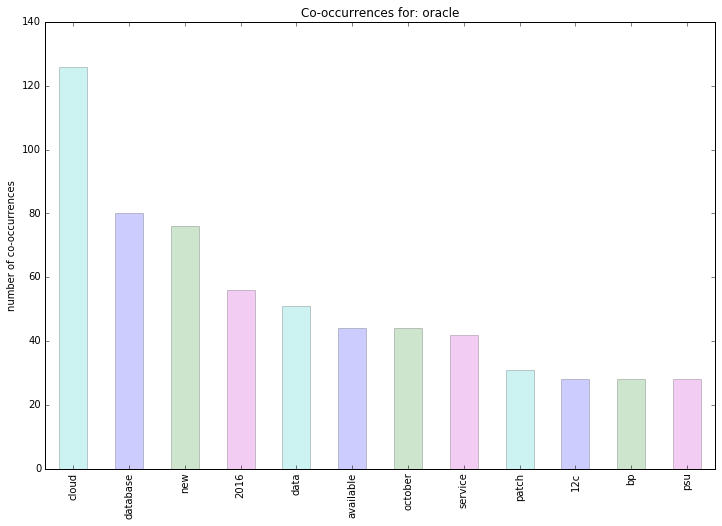

Co-occurrences for: microsoft
partners                27
iamcp                   26
city                    20
safer                   17
cloud                   15
msftcitynext            15
10                      14
windows                 13
event                   12
scewc16                 10
rsvp                    10
marketing@mint.co.za    10
Name: microsoft, dtype: int64




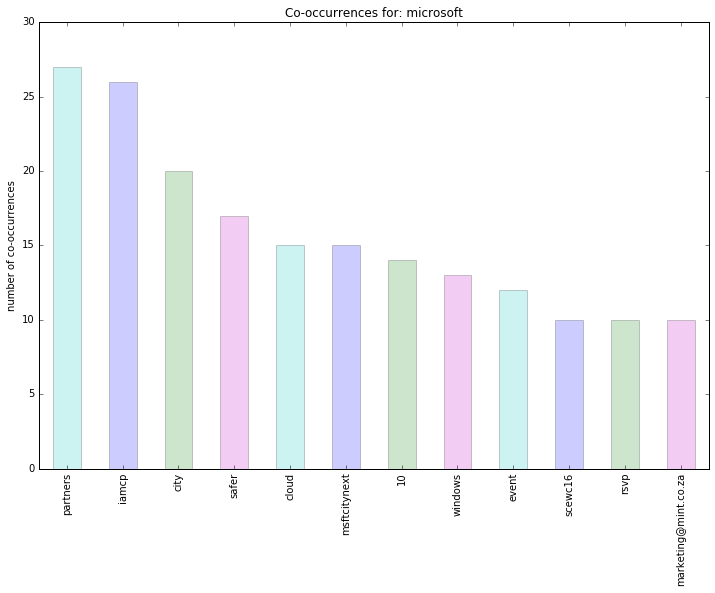

Co-occurrences for: talend
10                 55
bigdata            51
dataintegration    41
looks              33
back               33
bdiard             33
co-founder         33
etl                25
years              19
easy               19
machinelearning    19
made               19
Name: talend, dtype: int64




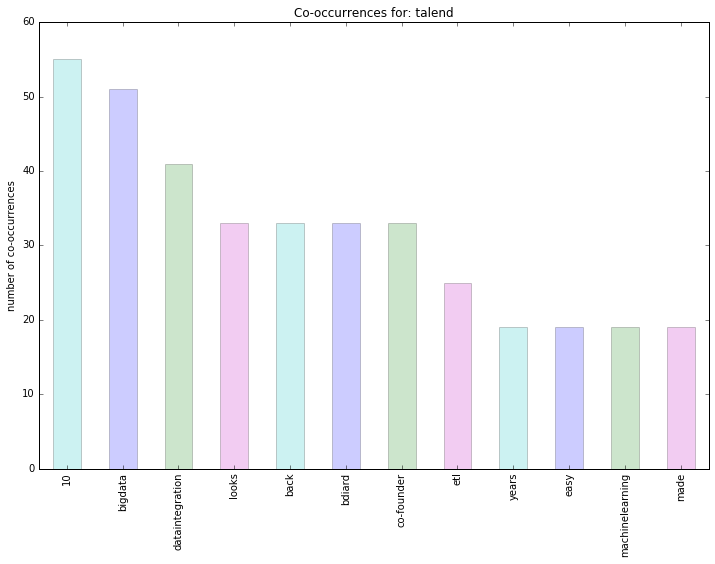

Co-occurrences for: bigdata
talend             51
hadoop             26
machinelearning    24
datascience        19
analytics          17
data               16
ai                 12
strategy           11
new                11
big                10
iot                10
berlin             10
Name: bigdata, dtype: int64




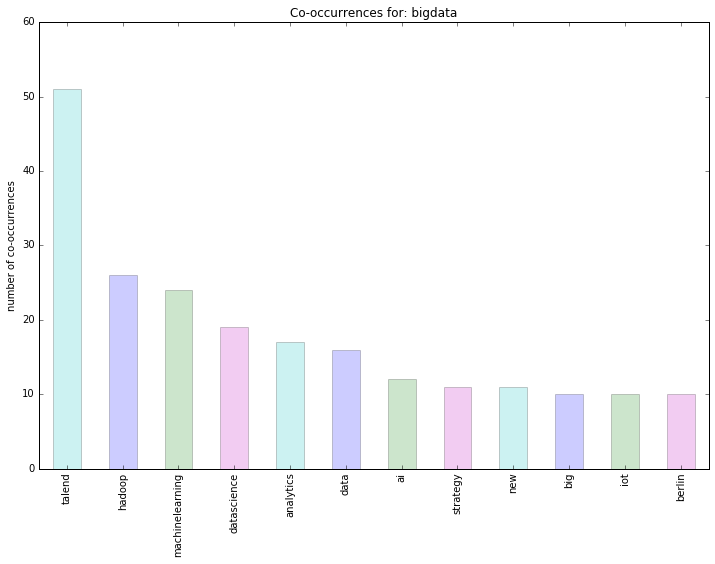

Co-occurrences for: cloud
oracle            126
oraclepartners     41
service            37
new                30
data               27
move               25
help               21
profit             19
free               19
coming             18
services           16
find               16
Name: cloud, dtype: int64




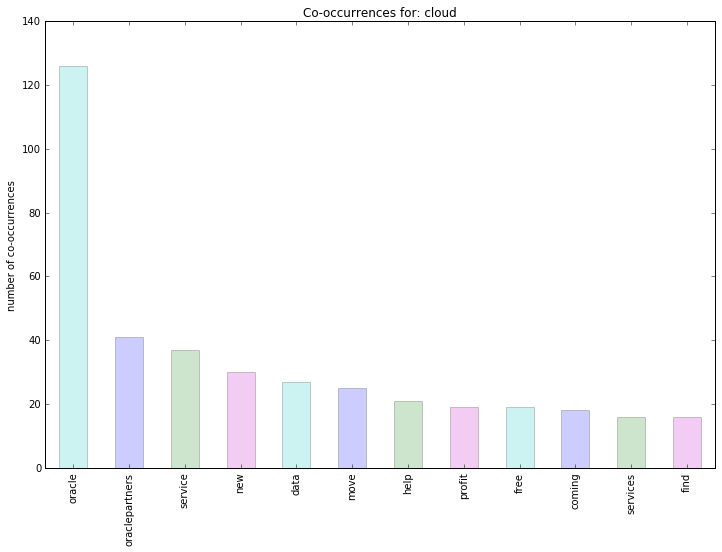

In [107]:
def get_co_occurrences(df, word, n):
    coocs = df.loc[word]
    sorted = coocs.sort_values(ascending = False)
    return sorted[:n]

def plot_co_occurrences(word, coocs):
    plt.figure(figsize = (12, 8))
    plt.ylabel('number of co-occurrences')
    plt.title('Co-occurrences for: {}'.format(word))
    coocs.plot(kind='bar', color = colors, alpha = 0.2)
    plt.show()
    
words = ['oracle', 'microsoft', 'talend', 'bigdata', 'cloud']    
n = 12
colors = 'cbgm'

for w in words: 
    coocs = get_co_occurrences(co_occurrences, w, n)
    print('Co-occurrences for: {}\n{}\n\n'.format(w, coocs))
    plot_co_occurrences(w, coocs)


# Tweets in German

In [108]:
tweets_german = pd.read_csv(german_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})
    
tweets_german['text_wo_#'] = tweets_german['text_processed'].apply(lambda x: remove_hash(x))
tweets_german['text_wo_#@'] = tweets_german['text_wo_#'].apply(lambda x: remove_at(x))

X_train_de = tweets_german['text_wo_#@'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("german"))
stopwords_nltk
#relevant_words = set(['aber', 'nicht', 'nichts', 'ohne', 'nur', 'sehr', 'sollte', 'viel'])
relevant_words = set()
additional_stopwords = set([''])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [34]:
X_train_de[-10:]

1748                             samsteiner Verwendest du XING_de oder LinkedIn ⁉ ️ bin dankbar um Retweets
1749    rszilinski Never ÜBERpromise Guter Rat in der Keynote pünktliche gute Ergebnisse sorgen für Vert...
1750    rogermathis Nerds wollen keine Chefs sein Problem ist inkompetente Kontrollfreaks legen Nerds zu...
1751    bigdata_insider Das Video zu den itawards 2016 ist online https://t.co/oH7tw4mIRk https://t.co/A...
1752              MSEnterpriseDE könntet ihr mal das GB Limit für onedrive erhöhen 5Gb ist ja wohl ein Witz
1753    Innere Kündigung Wenn der Mitarbeiter nur noch Dienst nach Vorschrift macht | impulse https://t....
1754    bigdata_insider Das Video zu den itawards 2016 ist online https://t.co/oH7tw4mIRk https://t.co/A...
1755    rszilinski esentri wir unterstützen Sie bei der Digitalisierung Sind Ihre Mitarbeiter Kunden glü...
1756    TDWI_EU Viele Anwender und Wissenschaftsberichte aus BI Business Analytics und Data Warehousing ...
1757    MSEnterpriseDE Ab 1 

In [35]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_de)
feature_names = vectorizer.get_feature_names()

In [36]:
lda_models = []
for n_topics in range(1,5):    
    lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
    lda.fit(words_matrix)
    lda_models.append(lda)

## Most dominating topics - overall - German

Topic #0:
109.9: javaforumnord
109.3: msenterprisede
85.8: https://t…
85.3: deutsche
81.8: sicherheit
78.8: msft
78.6: jfn16
77.4: setzt
75.8: mscloudde
75.0: danke



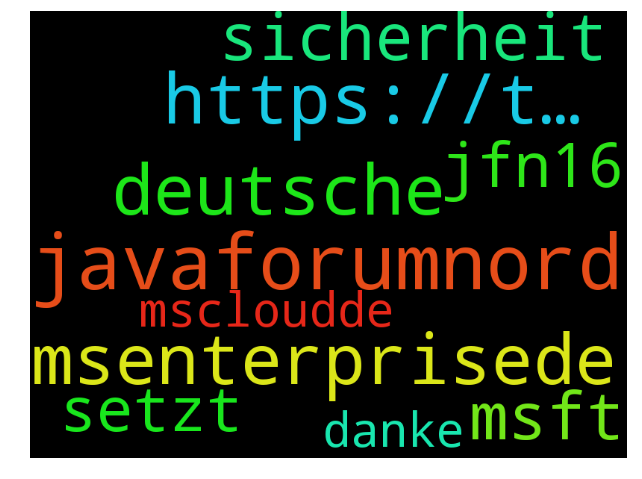

In [37]:
model = lda_models[0]
n_top_words = 10
print_top_words(model, n_top_words)

fig, ax1 = plt.subplots(figsize = (12, 8))
axes = [ax1]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 2 clusters - German

Topic #0:
94.6: javaforumnord
78.0: jfn16
58.2: itawards
55.8: java
49.3: heute
38.0: forum
37.4: neue
35.7: bigdata
34.9: geht
34.0: nord
31.9: cloudinsiderde
30.8: 2016
30.4: bigdata_insider
30.3: gibt
30.2: danke
28.7: newsletter
28.0: jahr
27.8: ab
27.8: mehr
25.6: app

Topic #1:
108.6: msenterprisede
85.2: https://t…
84.8: deutsche
81.3: sicherheit
78.3: msft
76.9: setzt
75.3: mscloudde
74.1: sicherheitszertifikat
74.1: d-trust
74.1: germany
74.1: made
65.0: cloud
52.8: oracle
44.8: danke
44.6: sap
43.7: “
36.8: „
31.8: unternehmen
30.7: november
30.1: orclapex



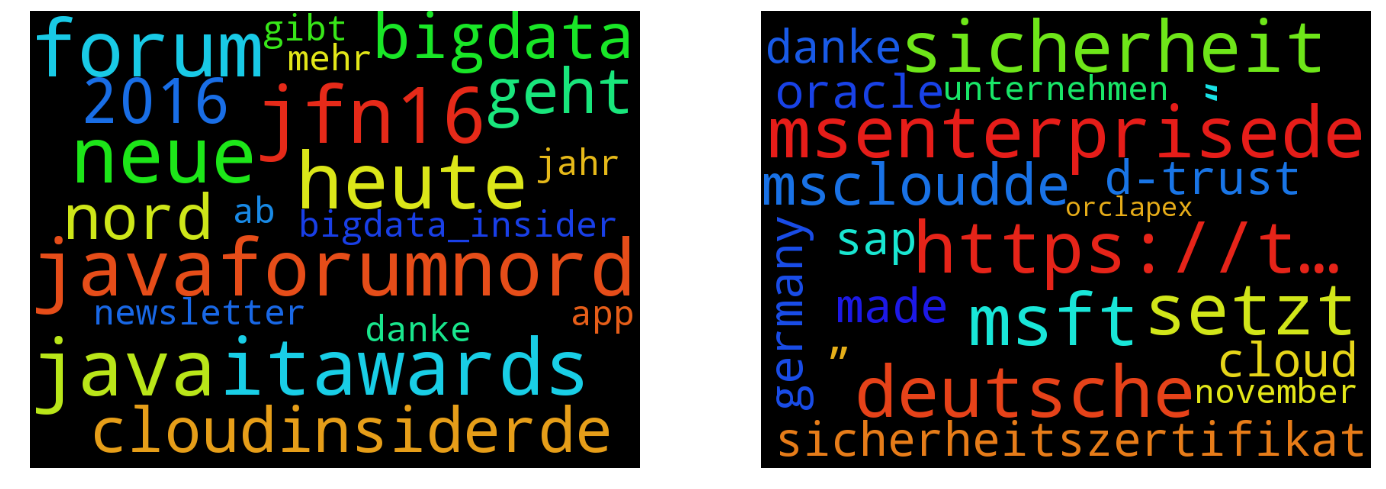

In [38]:
model = lda_models[1]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
axes = [ax1, ax2]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters - German

Topic #0:
98.5: javaforumnord
77.9: jfn16
55.7: java
38.7: heute
37.8: forum
37.2: neue
33.8: nord
33.5: geht
29.4: ab
28.8: bigdata
28.5: newsletter
27.8: jahr
27.0: schon
25.2: microsoftde
24.9: app
24.4: bigdata_insider
23.9: s
23.6: 2017
23.4: itawards
22.7: 2016

Topic #1:
108.6: msenterprisede
85.1: https://t…
84.6: deutsche
81.1: sicherheit
78.1: msft
76.8: setzt
75.1: mscloudde
73.9: made
73.9: sicherheitszertifikat
73.9: d-trust
73.9: germany
65.0: cloud
55.8: danke
53.8: oracle
45.6: sap
30.9: itawards
30.5: november
29.9: orclapex
28.9: doag2016
28.7: doagev

Topic #2:
43.4: “
36.5: „
28.4: ja
26.0: infograz
23.7: statt
23.7: digitalisierung
22.4: schweizer
22.0: unternehmen
21.0: nacht
20.1: :-)
20.0: fehring
20.0: bilder
19.2: 4
18.5: mal
18.3: itawards
16.2: braucht
15.9: schweiz
15.8: tdwi_eu
15.6: dunehopper
15.5: bi



(0.0, 1.0, 0.0, 1.0)

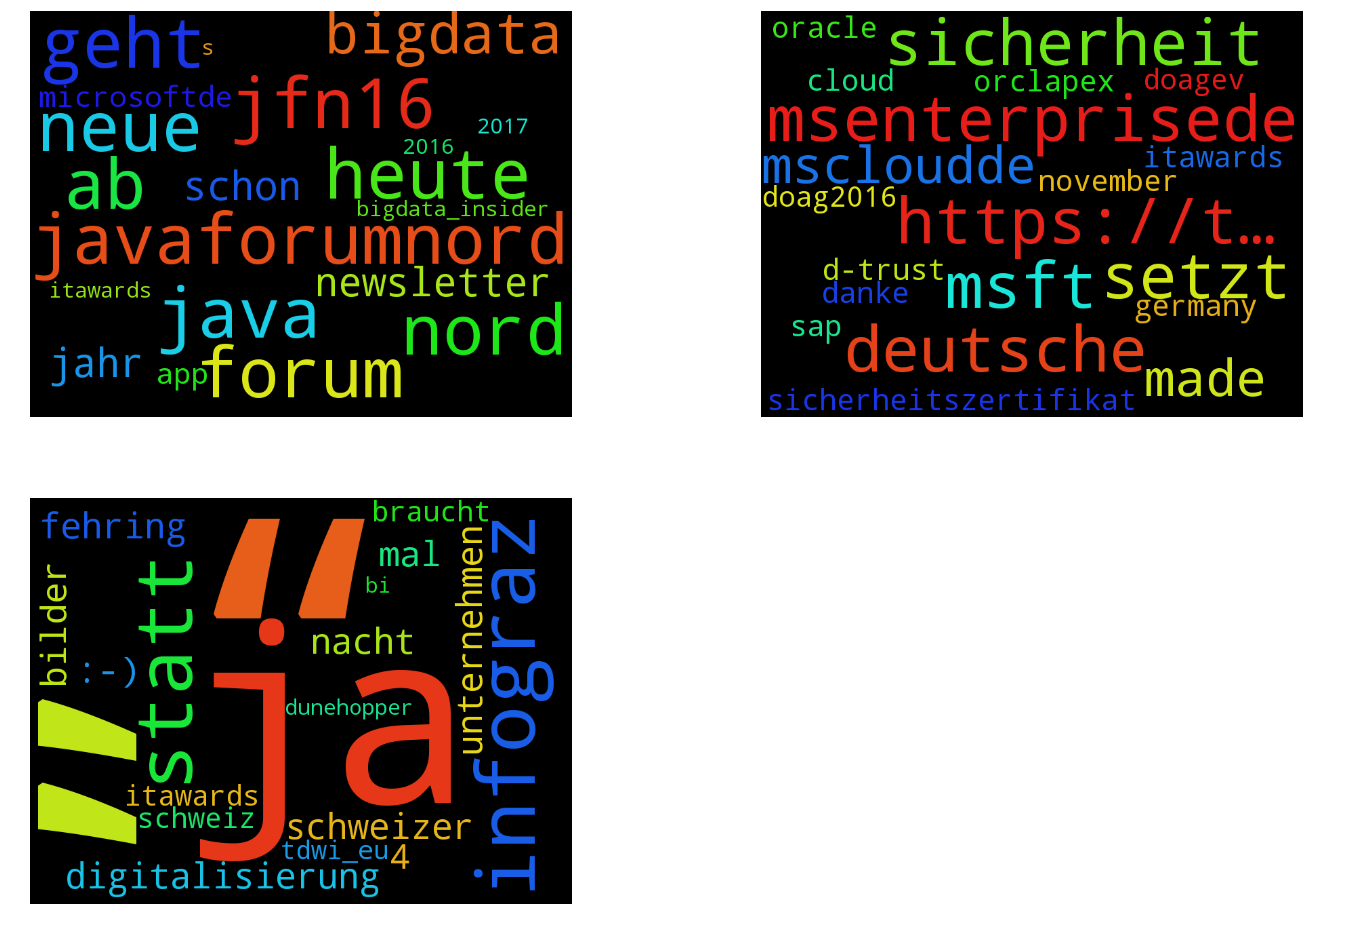

In [39]:
model = lda_models[2]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3]
show_word_clouds(model, axes, n_top_words)
ax4.axis('off')

## Most dominating topics - 4 clusters - German

Topic #0:
63.9: jfn16
55.6: java
52.9: javaforumnord
37.7: forum
37.2: neue
33.7: nord
31.1: itawards
30.6: bigdata
30.1: bigdata_insider
28.5: newsletter
27.2: heute
27.0: geht
23.9: s
23.5: 2017
23.0: app
22.8: https
22.8: gibt
21.8: gut
20.7: mehr
19.4: ;)

Topic #1:
95.3: msenterprisede
85.0: https://t…
84.5: deutsche
81.1: sicherheit
78.0: msft
76.7: setzt
75.0: mscloudde
73.9: made
73.9: sicherheitszertifikat
73.9: germany
73.9: d-trust
65.0: cloud
53.7: oracle
43.5: “
43.1: 2016
40.8: itawards
36.6: „
29.8: orclapex
27.6: cloudinsiderde
27.2: berlin

Topic #2:
35.4: 4
32.2: 2
24.1: sap
22.4: schweizer
21.4: social
20.9: nacht
20.6: sapdach
20.5: digitalisierung
20.1: :-)
18.3: event
17.2: ja
16.4: viele
16.1: nächsten
15.7: tdwi_eu
15.1: mal
15.0: 28
15.0: ganz
14.8: dwzurich16
14.6: apple
14.6: lange

Topic #3:
52.1: danke
50.7: javaforumnord
34.0: ab
30.5: november
27.3: schon
27.2: wer
25.9: a
22.5: jahr
22.5: dabei
21.1: infos
20.0: bilder
20.0: sagen
19.5: kommt
18.4: :)
18

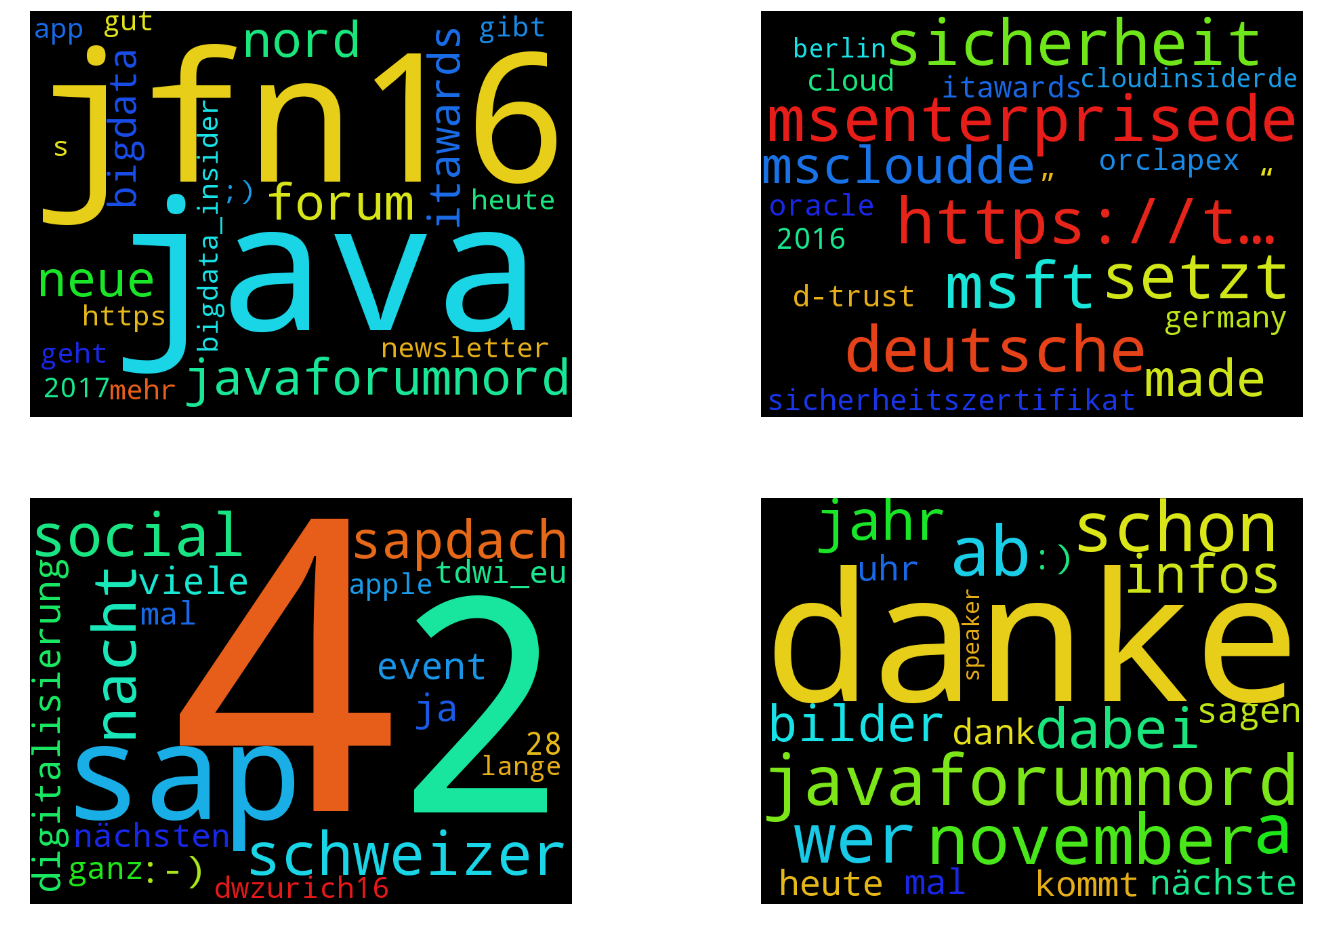

In [40]:
model = lda_models[3]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3, ax4]
show_word_clouds(model, axes, n_top_words)

Co-occurrences for: oracle
cloud              20
expertenseminar    14
doagev             14
martinberger_ch    13
oraclecloudday      9
anmelden            9
berlin              8
doag2016            7
danke               6
bereit              6
jet                 6
andreaskoop         6
Name: oracle, dtype: int64




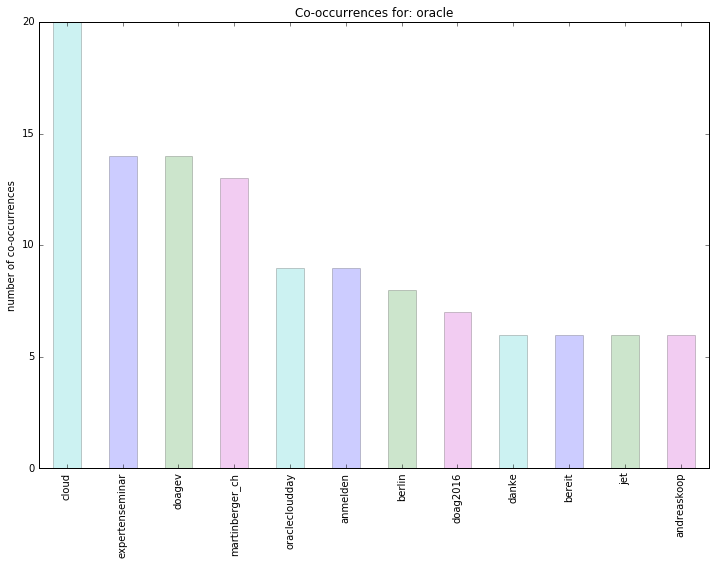

Co-occurrences for: microsoft
dpk16                      8
microsoftde                5
cloud                      5
2017                       3
bremen                     3
deutsche                   3
data                       2
https://t.co/pcrs8r8dev    2
kürt                       2
partner                    2
heute                      2
partnerkonferenz           2
Name: microsoft, dtype: int64




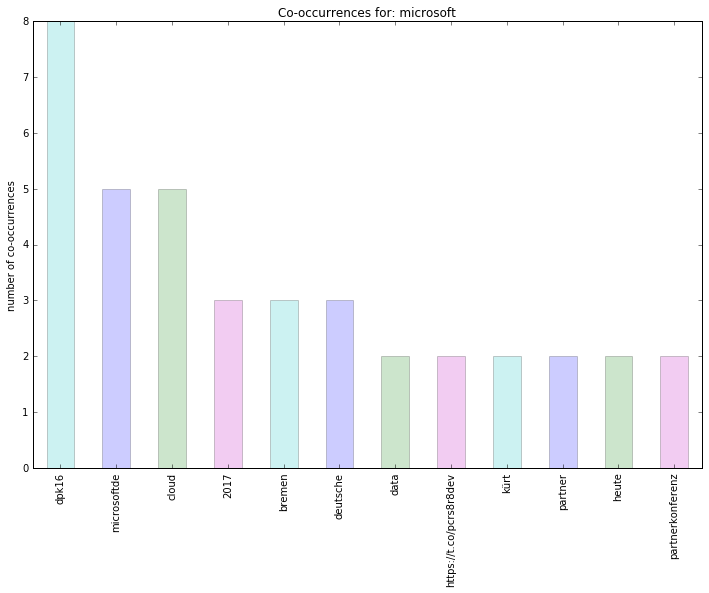

In [84]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_de)

co_occurrence_matrix = words_matrix.T * words_matrix
co_occurrence_matrix.setdiag(0) 
array = co_occurrence_matrix.toarray()
co_occurrences = pd.DataFrame(array)

vocab = vectorizer.get_feature_names()
co_occurrences['word'] = vocab
co_occurrences = co_occurrences.set_index('word')
co_occurrences.columns = vocab

words = ['oracle', 'microsoft']    
n = 12
colors = 'cbgm'

for w in words: 
    coocs = get_co_occurrences(co_occurrences, w, n)
    print('Co-occurrences for: {}\n{}\n\n'.format(w, coocs))
    plot_co_occurrences(w, coocs)

# Tweets in French

In [25]:
tweets_french = pd.read_csv(french_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})
    
tweets_french['text_wo_#'] = tweets_french['text_processed'].apply(lambda x: remove_hash(x))
tweets_french['text_wo_#@'] = tweets_french['text_wo_#'].apply(lambda x: remove_at(x))

X_train_fr = tweets_french['text_wo_#@'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("french"))
stopwords_nltk
relevant_words = set([])

additional_stopwords = set(['les'])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [26]:
X_train_fr[-10:]

55                                         Marc un suisse trop génial  tvog Vivement la vidéo sur YouTube
56    timhostettler Nous développons notre implantation en Suisse romande et recherchons un e Employé ...
57                    Allez-vous tester l adoption des vidéos en streaming direct https://t.co/2PSrTlSPqa
58    TalendFR Retrouvez Talend dès demain à Bruxelles pour le SparkSummit https://t.co/xGcHiro17V Spa...
59    Une attaque DDoS sur les services DNS de Dyn paralyse le web Net 4All vous en dit sur les attaqu...
60    salon eCom Genève le Journal est sorti de presse https://t.co/D6avNjCLxM Les unes d'aujourd'hui ...
61    TalendFR Retrouvez Talend dès demain à Bruxelles pour le SparkSummit https://t.co/xGcHiro17V Spa...
62    TalendFR C'est parti pour le SparkSummit Retrouvez nos experts BigData sur le stand Talend spark...
63    TalendFR Déposez votre carte de visite et tentez de gagner un drone sur le stand Talend Tirage a...
64    Canon soutient les Internationale Kurzfi

In [27]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_fr)
feature_names = vectorizer.get_feature_names()

In [28]:
lda_models = []
for n_topics in range(1,5):    
    lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
    lda.fit(words_matrix)
    lda_models.append(lda)

## Most dominating topics - overall - French

Topic #0:
11.4: oracle_france
9.8: welovestartups
9.0: oracle
8.2: oracledigital
8.2: talendfr
8.2: rdv
7.5: day
7.4: bigdata
7.4: jpmichenaud
6.6: talend



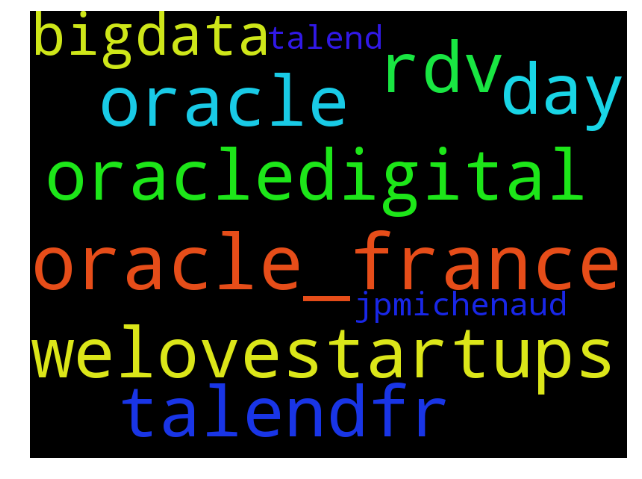

In [29]:
model = lda_models[0]
n_top_words = 10
print_top_words(model, n_top_words)

fig, ax1 = plt.subplots(figsize = (12, 8))
axes = [ax1]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 2 clusters - French

Topic #0:
7.6: oracle_france
7.5: welovestartups
5.1: day
4.7: jpmichenaud
3.8: bigdata
3.8: talendfr
3.8: frdigitale
3.8: damiengromier
3.8: https://t.co/yyohfsispq
3.8: table-ronde
3.8: start-ups
3.8: ceo
3.7: anime
3.0: gérard
3.0: swissdataforum
3.0: we
3.0: competitive
3.0: at
3.0: 2016
3.0: reward

Topic #1:
8.5: oracle
7.7: rdv
7.1: oracledigital
5.4: e
5.4: 8
5.3: nov
4.6: talendfr
4.5: talend
4.0: oracle_france
3.9: sparksummit
3.8: bigdata
3.0: strauch5
3.0: https://t.co/4jbuphyxsi
3.0: jpmichenaud
2.9: cloud
2.9: suisse
2.8: recommendations
2.7: blog
2.6: day
2.5: welovestartups



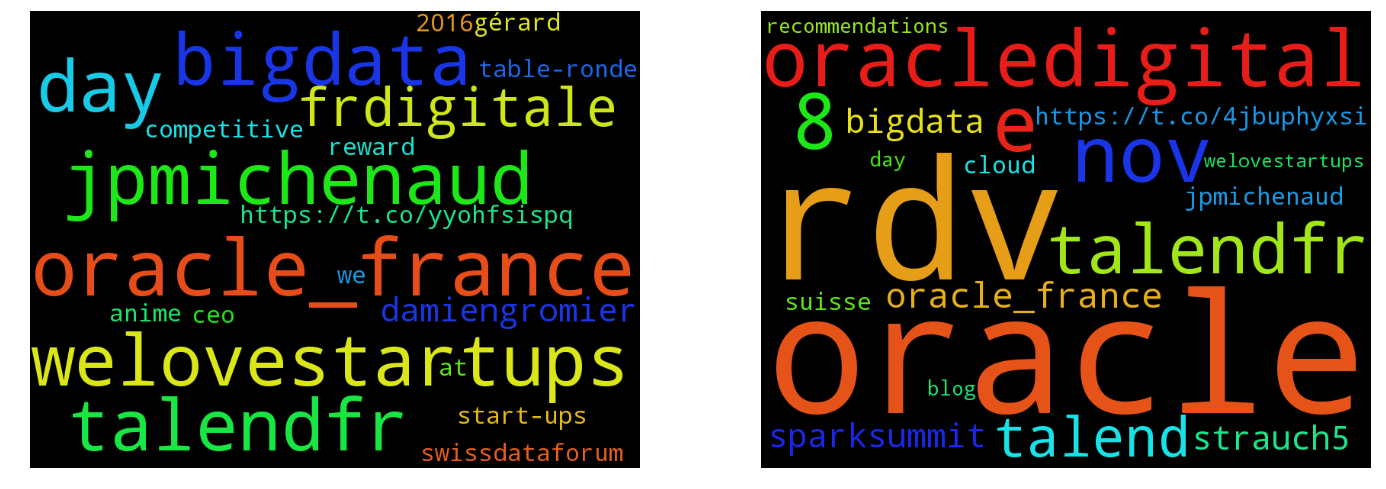

In [30]:
model = lda_models[1]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
axes = [ax1, ax2]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters - French

Topic #0:
4.5: welovestartups
4.5: oracle_france
3.7: damiengromier
3.7: https://t.co/yyohfsispq
3.7: frdigitale
3.7: table-ronde
3.7: start-ups
3.6: anime
2.9: jpmichenaud
2.6: recommendations
2.6: blog
2.2: oracle
2.1: :-)
2.1: https://t.co/dbxy4iat48
2.1: monde
2.1: suisse
2.1: journal
2.1: là
2.1: swissdataforum
2.1: d'aujourd'hui

Topic #1:
6.1: oracle
6.0: rdv
5.3: talendfr
5.2: talend
5.2: oracledigital
5.2: 8
5.2: nov
4.5: oracle_france
4.4: sparksummit
4.4: bigdata
2.9: jpmichenaud
2.9: strauch5
2.9: welovestartups
2.9: day
2.8: cloud
2.8: retrouvez
2.1: a
2.1: 19
2.1: décembre
2.1: sql

Topic #2:
3.7: e
3.7: day
3.0: oracledigital
2.9: ceo
2.9: 2016
2.9: at
2.9: offer
2.9: appyreward
2.9: oracle_france
2.9: digital
2.9: gérard
2.9: fournier
2.9: competitive
2.9: reward
2.9: welovestartups
2.9: we
2.8: sol
2.1: inscrivez-vous
2.1: rdv
2.1: nipconf



(0.0, 1.0, 0.0, 1.0)

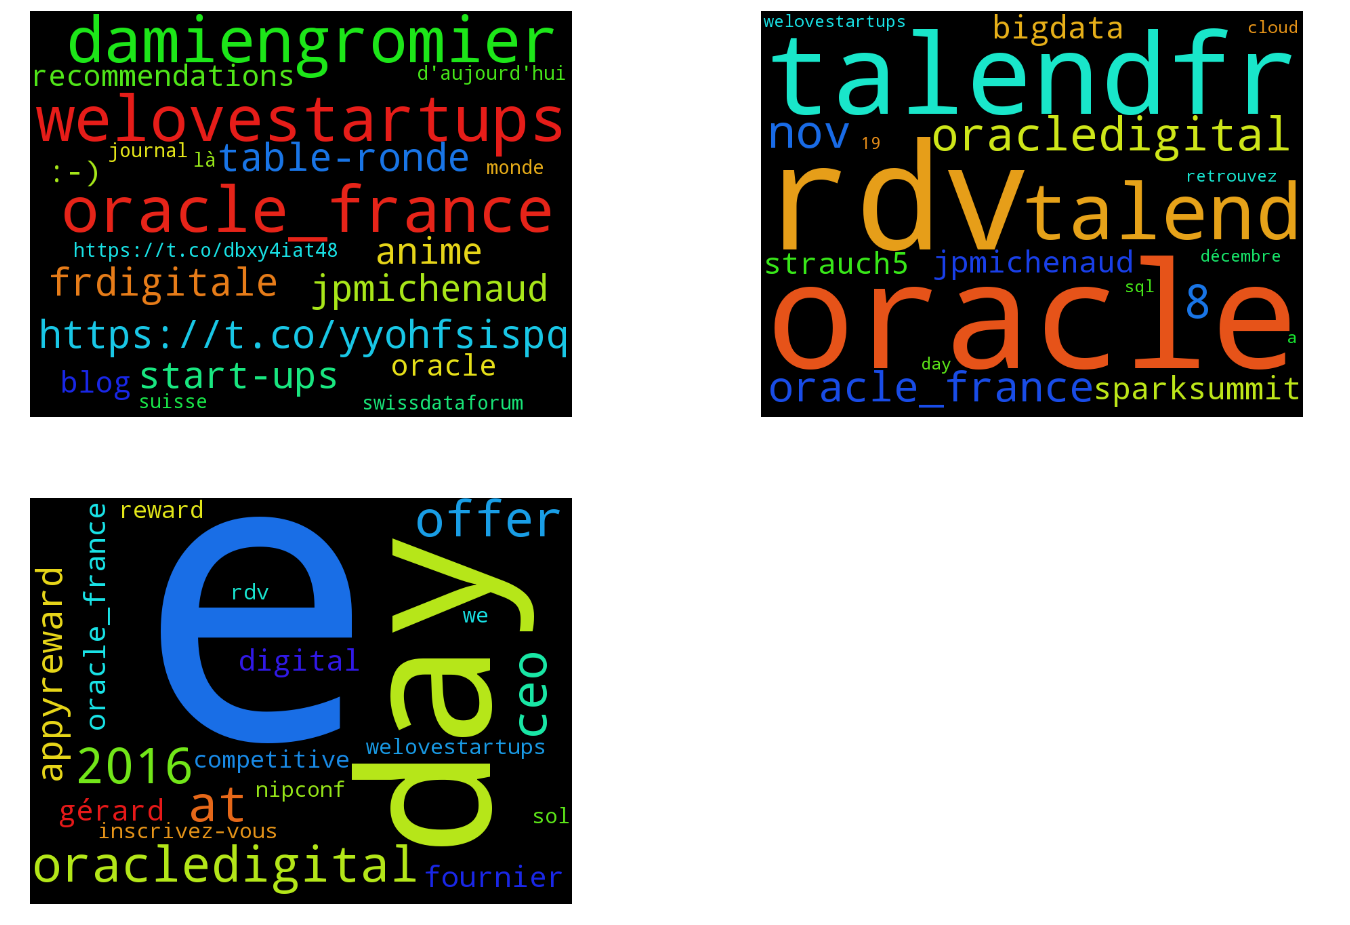

In [31]:
model = lda_models[2]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3]
show_word_clouds(model, axes, n_top_words)
ax4.axis('off')

## Most dominating topics - 4 clusters - French

Topic #0:
4.4: welovestartups
4.4: oracle_france
3.6: damiengromier
3.6: https://t.co/yyohfsispq
3.6: frdigitale
3.6: table-ronde
3.6: start-ups
3.6: anime
2.8: jpmichenaud
2.8: talend
2.8: talendfr
2.0: :-)
2.0: https://t.co/dbxy4iat48
2.0: day
2.0: entreprises
2.0: là
2.0: suisse
2.0: swissdataforum
2.0: bigdata
2.0: stand

Topic #1:
8.4: oracle
4.4: oracle_france
3.6: rdv
2.8: strauch5
2.8: welovestartups
2.8: day
2.8: oracledigital
2.8: 8
2.8: nov
2.8: cloud
2.7: recommendations
2.7: blog
2.0: jpmichenaud
2.0: 19
2.0: l'écoute
2.0: décembre
2.0: sql
2.0: by
2.0: besoins
2.0: https://t.co/9kwgglqxte

Topic #2:
3.6: e
2.8: 2016
2.8: at
2.8: oracledigital
2.8: ceo
2.8: offer
2.8: appyreward
2.8: digital
2.8: gérard
2.8: fournier
2.8: competitive
2.8: oracle_france
2.8: day
2.8: reward
2.8: we
2.8: welovestartups
2.8: rdv
2.8: sol
2.0: inscrivez-vous
2.0: nipconf

Topic #3:
3.7: sparksummit
3.7: bigdata
3.6: talendfr
3.6: talend
2.0: commande
2.0: comment
2.0: dès
2.0: demain
2.0: donn

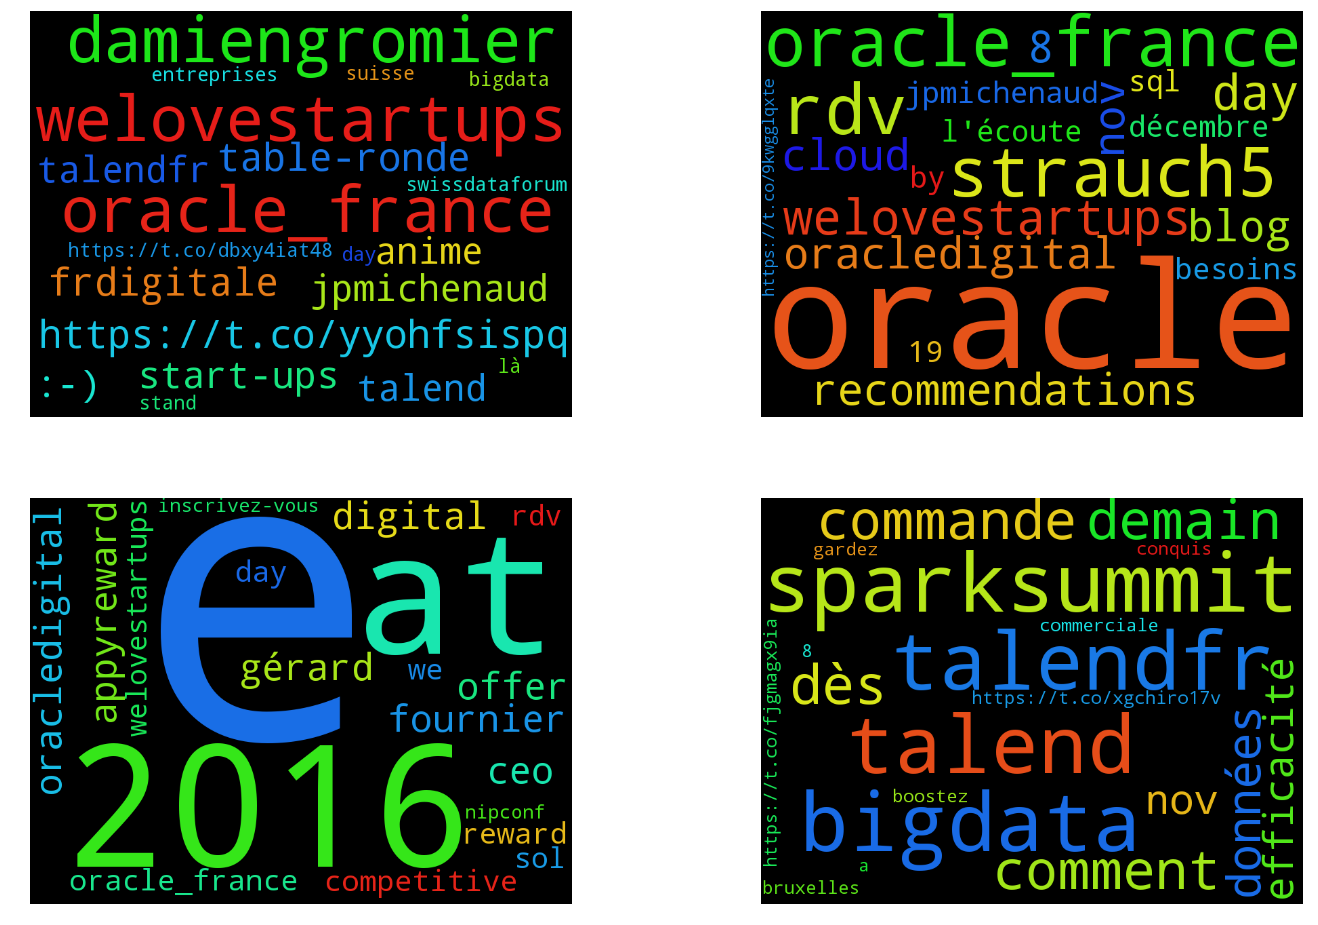

In [32]:
model = lda_models[3]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3, ax4]
show_word_clouds(model, axes, n_top_words)

Co-occurrences for: oracle
au                 4
à                  4
recommendations    3
blog               3
strauch5           3
on                 2
exécution          2
entreprise         2
introduction       2
by                 2
le                 2
de                 2
Name: oracle, dtype: int64




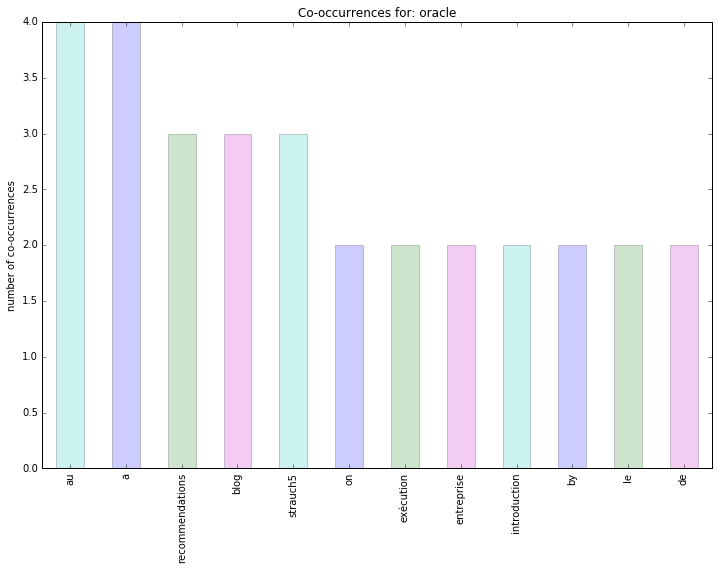

KeyError: 'the label [microsoft] is not in the [index]'

In [85]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_fr)

co_occurrence_matrix = words_matrix.T * words_matrix
co_occurrence_matrix.setdiag(0) 
array = co_occurrence_matrix.toarray()
co_occurrences = pd.DataFrame(array)

vocab = vectorizer.get_feature_names()
co_occurrences['word'] = vocab
co_occurrences = co_occurrences.set_index('word')
co_occurrences.columns = vocab
co_occurrences.head()

words = ['oracle', 'microsoft']    
n = 12
colors = 'cbgm'

for w in words: 
    coocs = get_co_occurrences(co_occurrences, w, n)
    print('Co-occurrences for: {}\n{}\n\n'.format(w, coocs))
    plot_co_occurrences(w, coocs)